# Nested Sampling with `dynesty`: The Basics

This is a simple interactive demo that briefly goes over nested sampling and some of the features available in `dynesty`. This is meant to be a living document that will eventually get turned into documentation at some point in the future.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

# Overview

In the context of Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form commonly known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

**Nested sampling** [(Skilling 2006)](https://projecteuclid.org/euclid.ba/1340370944) attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within an **iso-likelihood contour** set by $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. 

More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $1 > X_0 > X_1 > \dots > X_i > \dots > X_N > 0$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## Basics of Nested Sampling

### Evidence Estimation

We start with a number of $K$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we remove the live point with the lowest likelihood $\mathcal{L}_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_i$. It can be shown through some neat statistical arguments (which are outlined in more detail below) that this sampling procedure actually allows us to approximate the prior volume of the previous live point (a **"dead" point**) based on the current iteration as

$$ \ln X_i \approx -\left(i \pm \sqrt{i}\right)/K \quad .$$

This enables us to directly estimate the evidence (and errors) using a set of $N$ dead points via

$$ \mathcal{Z} = \int_{0}^{1} \mathcal{L}(X) \, dX \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \, f(\mathcal{L}_i) \, w_i $$

where $w_i \equiv \Delta X_i$ is the associated weight. As an example, for a simple linear integration scheme using rectangles, we can take $f(\mathcal{L}_i) = \mathcal{L}_i$ and $w_i = X_{i-1} - X_i$. If we want to use a quadratic integration scheme with trapezoids (used by `dynesty`), we instead can take $f(\mathcal{L}_i) = (\mathcal{L}_{i-1} + \mathcal{L}_i) / 2$.

### Posterior Estimation

We can subsequently estimate posteriors "for free" from the same $N$ dead points used to compute the evidence by assigning each sample its associated **importance weight**

$$ P(\boldsymbol{\Theta}_i) \equiv p_i \approx \hat{p}_i = \frac{\mathcal{L}_i w_i}{\sum_{i=1}^{N} \mathcal{L}_i w_i} = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}} \propto \mathcal{L}_i w_i \quad . $$

### Stopping Criteria

The remaining prior volume $\Delta \mathcal{Z}_i$ at iteration $i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multiplied by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This essentially assumes that the remaining prior volume interior to the last dead point is a uniform slab with likelihood $\mathcal{L}_{\max}$. In general, this error estimate serves as a rough upper bound (since $X_i$ is not exactly known) that can be used for deciding when to stop sampling from an arbitrary distribution while estimating the total evidence. Other stopping criteria are discussed later.

### Challenges

Nested sampling has two main main theoretical requirements:
1. Samples must be drawn sequentially, subject to the hard likelihood constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_{i}$, and
2. All samples used to compute/replace live points are **independent and identically distributed (i.i.d.)** random variables drawn from the prior.

The first requirement is entirely algorithmic and easy to satisfy. The second requirement, however, is much more difficult to satisfy if we hope to sample the likelihood efficiently: while it is straightforward to generate samples from the prior, by design nested sampling makes this simple sampling scheme increasingly more inefficient since our remaining prior volume shrinks over time.

Solutions to this problem often involve some combination of:
1. Proposing new live points by "evolving" a copy of one (or more) current live points to new (independent) positions within the likelihood constraint, and
2. (Approximately) bounding the iso-likelihood contours using simple but flexible functions in order to exclude regions with lower likelihoods.

In both cases, it is much easier to deal with uniform (rather than arbitrary) priors. As a result, most nested sampling algorithms/packages (including `dynesty`) are designed to sample within the $n$-dimensional unit cube. Samples are transformed samples back to the original parameter space "on the fly" only when necessary to evaluate the likelihood. Accomplishing this requires an appropriate **prior transform** (i.e. the inverse CDF). 

Some examples of priors transforms can be found in `priors.py`.

# Demonstration on 3-D Correlated Multivariate Normal

Let's get a sense for how `dynesty` works using a strongly correlated 3-D **multivariate Normal** distribution.

In [3]:
import dynesty

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

As described above, `dynesty` samples over the unit cube. We'll define our prior to be uniform in each dimension from -10. to 10 and 0 everywhere else. We now define the function that transforms our unit cube samples to samples from the prior.

In [5]:
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

## Sampling the Target Distribution

### Bounding Options

`dynesty` supports a number of methods for bounding the target distribution:
- **no bound** (`'none'`), i.e. sampling from the entire unit cube,
- a **single bounding ellipsoid** (`'single'`),
- **multiple** (possibly overlapping) **bounding ellipsoids** (`'multi'`),
- **overlapping balls** centered on each live point (`'balls'`), and
- **overlapping cubes** centered on each live point (`'cubes'`).

**By default, `dynesty` uses multi-ellipsoidal decomposition (`'multi'`)**, which often is flexible enough to capture the complexity of many likelihood distributions while simple enough to quickly and efficiently generate new samples. For more complex distributions, overlapping balls (`'balls'`) or cubes (`'cubes'`) can generate more flexible bounding distributions but come with significantly more overhead and are less efficient at generating samples. For simpler distributions, a single ellipsoid (`'single'`) is often sufficient. Sampling directly from the unit cube (`'none'`) is extremely inefficient but is a useful option to verify your results and look for possible biases. It otherwise should only be used if the log-likelihood is trivial to compute.

### Sampling Options

`dynesty` also supports several different sampling methods conditioned on those bounds:
- **uniform** sampling (`'unif'`),
- **random walks** away from a current live point (`'rwalk'`), and
- **slice sampling** away from a current live point (`'slice'`).

**By default, `dynesty` samples uniformly within the bounding distribution (`'unif'`)**. In low dimensions ($d \lesssim 10$), uniform sampling is quite efficient at generating new live point proposals. In moderate dimensions ($d \sim 5-15$), random walks (`'rwalk'`) often can be similarly efficient. In moderate-to-high dimensions ($d \gtrsim 20$), sampling techniques that do not rely on rejecting new proposed points such as multivariate slice sampling (`'slice'`) become progressively more efficient.

We'll return to these different options a bit later.

## The Nested Sampler

Standard nested sampling in `dynesty` can be done using the `NestedSampler` "class" (a catch-all term for the individual `nestedsampler` objects associated with each bounding function). There are only 3 required arguments: a log-likelihood function, a prior transform function, and the number of dimensions taken by the loglikelihood.

Let's now initialize our nested sampler. We'll use $K=1000$ live points (rather than the default $K=100$) along with `dynesty`'s default bounding/sampling modes: multi-ellipsoidal bounds ([Feroz et al. 2008, 2013](https://arxiv.org/abs/1306.2144)) with new live points proposed uniformly within the set of (possibly overlapping) ellipsoids. These tend to give very efficient proposals in low-to-moderate dimensions ([Handley et al. 2015](https://arxiv.org/abs/1506.00171)). By default, `dynesty` uses **bootstrap resampling** (with 20 realizations as a default) to ensure our proposal distribtions do not overly-constrain the remaining likelihood distribution ([Buchner 2014](https://arxiv.org/abs/1407.5459)), which works well in general but can significantly increase overhead when many ellipsoids are required to bound the likelihood distribution.

### Sidenote: Bounding Parameters

In addition to the chosen proposal, we also need to make two additional choices. The first is at what point we want to initialize our *first* bounding distribution, i.e. when we want to transition from sampling using the unit cube to sampling using our chosen bound(s). Bounding points too early can lead to proposals whose volume significantly exceeds that of the unit cube, leading to inefficient sampling when sampling uniformly. By default, `dynesty` waits until `2 * nlive` function calls have been made and the overall efficiency drops below 10% before triggering an update when sampling uniformly (and otherwise updates immediately).

The second is how frequently we should update our bounding distribution. Updating our bounds too frequently can lead to large computational overhead, while triggering them too infrequently can significantly reduce sampling efficiency. By default, `dynesty` updates our bounds after `0.6 * nlive` function calls.

In [6]:
# initialize our nested sampler
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, nlive=1000)

### Sampling Internally

We can now begin sampling from our target distribution. Sampling will continue until the specified stopping criteria are reached, which can be any combination of:
- a fixed number of iterations (`maxiter`), 
- a fixed number of likelihood calls (`maxcall`), or
- a specified $\Delta \ln \hat{\mathcal{Z}}_i \equiv \ln \hat{\mathcal{Z}}_{\textrm{est}} - \ln \hat{\mathcal{Z}}_i$ tolerance (`dlogz`) between the estimated total evidence $\hat{\mathcal{Z}}_{\textrm{est}}$ and the currently computed evidence $\hat{\mathcal{Z}}_i$. 

`NestedSampler` is designed for evidence estimation (posteriors are a nice byproduct). The stopping criteria defaults to $\Delta \ln \hat{\mathcal{Z}}_i < 0.005 (K+1)$ if we intend to "recycle" the final set of live points that otherwise are wasted (`add_live=True`; this is the default behavior) and $\Delta \ln \hat{\mathcal{Z}}_i < 0.01$ otherwise, with no real limit placed on `maxiter` and `maxcall`.

By default, `NestedSampler` also outputs its progress in real time to `stderr` along with a set of useful summary statistics including: the current iteration, number of calls (current and total), overall sampling efficiency, current $\ln \mathcal{Z}$ estimate, and estimated `dlogz`.

In [7]:
# sample from the target distribution
sampler.run_nested()

iter: 6718+1000 | nc: 1 | ncall: 39582 | eff(%): 19.499 | logz: -8.832 +/-  0.132 | dlogz:  0.006 <  5.005    


At a glance, our results look pretty good overall. In particular, our sampling efficiency over the course of our $\sim 7.5$k samples is $\sim 65\%$, significantly higher than other sampling methods such as **Markov Chain Monte Carlo** (which often are tuned to give $\sim 15\%$), especially given that our samples are (in theory) i.i.d. We'll return to this comparison in more detail later.

### Results

The results can be accessed after a run via `sampler.results` and are stored as a modified dictionary. We can get a quick summary of our results using the `summary()` method, although the actual file contains a host of information about the nested sampling run.

In [8]:
res = sampler.results  # grab our results
print('Keys:', res.keys(),'\n')  # print accessible keys
res.summary()  # print a summary

Keys: ['niter', 'logvol', 'prop_iter', 'samples_id', 'logz', 'ncall', 'scale', 'samples_prop', 'nlive', 'samples', 'h', 'samples_u', 'samples_it', 'logl', 'prop', 'logzerr', 'eff', 'logwt'] 

Summary
nlive: 1000
niter: 6718
ncall: 39582
eff(%): 19.499
logz: -8.832 +/-  0.132


The most relevant quantities for a general user will be **`samples`** (the collection of samples from the run), **`logwt`** (their corresponding ln-importance weights), **`logz`** (the cumulative ln-evidence), and **`logzerr`** (the error on the ln-evidence). The remaining quantities are used to help visualize the output (see below) and will also be useful for more advanced users who want additional information about the nested sampling run. 

In detail, quantities included in the `Results` dictionary are:
- **`nlive`**: the number of live points,
- **`niter`**: the number of iterations,
- **`ncall`**: the total number of function calls,
- **`eff`**: the overall efficiency,
- **`samples`**: the set of samples in the native model space,
- **`samples_u`**: the set of samples on the unit cube,
- **`samples_id`**: the unique particle index associated with each sample,
- **`samples_it`**: the iteration the sample was originally proposed,
- **`logwt`**: the log-importance weight associated with each sample,
- **`logl`**: the log-likelihoods associated with each sample,
- **`logvol`**: the (expected) log-prior volume associated with each sample,
- **`logz`**: the cumulative evidence at each iteration,
- **`logzerr`**: the error (standard deviation) on `logz` at each iteration, and
- **`h`**: the "information" at each iteration.

If the proposals/bounds are also saved (the default behavior), then the following quantities are also included:
- **`prop`**: a copy of the set of bounding proposal objects,
- **`prop_iter`**: the index of the bounding proposal currently active at a given iteration,
- **`samples_prop`**: the index of the bounding object the sample was originally from, and
- **`scale`**: the scale-factor used at a given iteration (used to scale bounds for non-uniform proposals).

## Extending a Run

Let's see if we can do any better by adding more samples (dead points) until an even more stringent stopping criterion is met. By default, `dynesty` keeps track of the live points and final set of samples, making it easy to add additional samples to the same run.

In [9]:
sampler.run_nested(dlogz=0.1)

iter: 10866+1000 | nc: 1 | ncall: 46032 | eff(%): 25.778 | logz: -8.818 +/-  0.085 | dlogz:  0.000 <  0.100    


### Sampling Externally

In addition to having our samples generated entirely internally to our `NestedSampler` object via `run_nested()`, `dynesty` can also be run explicitly as a **generator** using the `sample()` option. We demonstrate this feature below, again continuing where we originally left off to add even more samples to our current run.

In [10]:
dlogz_final = 0.01

# continue sampling from where we left off
ncall = sampler.ncall  # internal calls
nit = sampler.it  # internal iteration
for it, results in enumerate(sampler.sample(dlogz=dlogz_final)):
    # split up our results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, propidx, propiter, eff, delta_logz) = results
    # add number of function calls
    ncall += nc
    # format/output results
    if delta_logz > 1e6:
        delta_logz = np.inf
    if logzvar >= 0.:
        logzerr = np.sqrt(logzvar)
    else:
        logzerr = np.nan
    sys.stderr.write("\riter: {:d} | nc: {:d} | ncall: {:d} | eff(%): {:6.3f} | "
                     "logz: {:6.3f} +/- {:6.3f} | dlogz: {:6.3f} > {:6.3f}      "
                     .format(nit + it, nc, ncall, eff, logz, 
                             logzerr, delta_logz, dlogz_final))
    sys.stderr.flush()

# add the remaining live points back into our final results 
# (they are removed from our set of dead points each time we start sampling)
for it2, results in enumerate(sampler.add_live_points()):
    # split up results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, propidx, propiter, eff, delta_logz) = results
    # format/output results
    if delta_logz > 1e6:
        delta_logz = np.inf
    if logzvar >= 0.:
        logzerr = np.sqrt(logzvar)
    else:
        logzerr = np.nan
    sys.stderr.write("\riter: {:d}+{:d} | nc: {:d} | ncall: {:d} | eff(%): {:6.3f} | "
                     "logz: {:6.3f} +/- {:6.3f} | dlogz: {:6.3f} < {:6.3f}      "
                     .format(nit + it, it2+1, nc, ncall, eff, logz,
                             logzerr, delta_logz, dlogz_final))
    sys.stderr.flush()

res2 = sampler.results

iter: 13139+1000 | nc: 1 | ncall: 49499 | eff(%): 28.564 | logz: -8.818 +/-  0.084 | dlogz:  0.000 <  0.010      

At this point, note that our estimated evidence $\ln \mathcal{Z}_i$ from our original run (`res`) and this extended run (`res2`) are almost identical even though we've almost doubled the total number of samples, although the effective error is somewhat smaller. This demonstrates how much we can gain by "recycling" the final set of live points.

# Sampling in Parallel

`dynesty` also supports multi-processing to evaluate likelihood functions in parallel through a user-provided `pool`. The only requirements are that the pool has a `map` function and supports advanced pickling (via `dill` or `cloudpickle`). Although parallelization is unhelpful in this particular case, we'll showcase a quick example of how to provide an appropriate pool before moving on.

We will use the excellent **[`ipyparallel`](https://ipyparallel.readthedocs.io/en/latest/)** package to support our parallelization. In this particular example, the underlying cluster is also running the [MPICH](http://www.mpich.org/) implementation of [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface). See the [`ipyparallel` documentation](https://ipyparallel.readthedocs.io/en/latest/) for additional information on getting set up.

In [11]:
import ipyparallel as ipp

Once we have `ipyparallel` imported and a cluster up and running, we need to create a "client" to interface with our processors.

In [12]:
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

[0, 1, 2, 3, 4, 5, 6, 7]


To enable direct execution, we will then make used of a `DirectView` object and set it to use `dill` instead of the default `pickle`.

In [13]:
dview = rc[:]
dview.use_dill();

Although our processors have now been initialized, they do not share global memory. We now need to initialize each member of the group with the same global environment. This can be done using the `%%px` magic function, which automatically runs all commands below it in the same cell in parallel.

In [14]:
%%px

# import environment
from __future__ import division, print_function
from builtins import range
import time, sys, os
import numpy as np
import math
from numpy import linalg
import dynesty

# define likelihood constants
ndim = 3
C = np.identity(ndim)
C[C==0] = 0.95
Cinv = linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))

In [15]:
# seed the random number generator
for i in rc.ids:
    with rc[i].sync_imports():
        np.random.seed((i+1)*100)

The final step is to create an appropriate `pool`. By default, `dview.map` aliases an *asynchronous* map whose results can be accessed afterwards. We, however, require `map` a simpler, *synchronous* map that just returns the results of the distributed computation in one batch. This just requires wrapping the `dview.map_sync` function.

In [16]:
class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

With that, our pool is all set! By default, `dynesty` will use our pool to compute most bulk operations in parallel. Since our likelihood computations are quite quick, here we'll opt to propose new points in serial by specifying the appropriate `use_pool` flag.

In [17]:
psampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, nlive=1000,
                                 pool=pool, queue_size=nprocs, use_pool={'propose_point': False})

In [18]:
psampler.run_nested(dlogz=0.01)
pres = psampler.results

iter: 13338+1000 | nc: 1 | ncall: 50534 | eff(%): 28.373 | logz: -9.014 +/-  0.085 | dlogz:  0.000 <  0.010    


# Results

Let's see how we did!

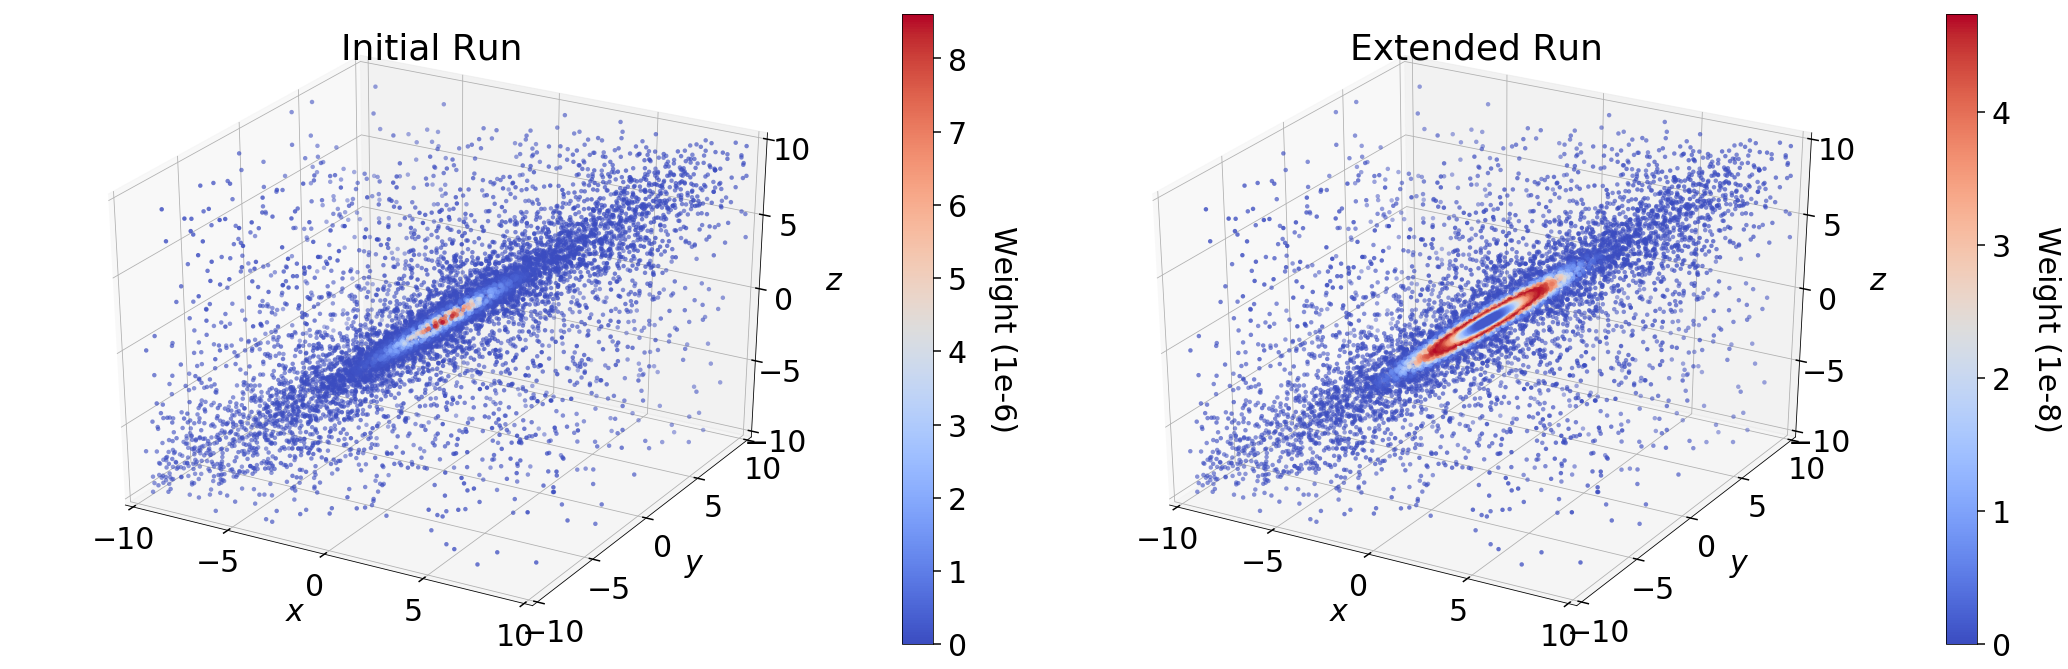

In [19]:
# 3-D plots of position and likelihood, colored by weight
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(121, projection='3d')

# plotting the initial run
p = ax.scatter(res.samples[:, 0], res.samples[:, 1], res.samples[:, 2],
               marker='o', c=np.exp(res.logwt) * 1e7, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xticks(np.linspace(-10., 10., 5))
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_yticks(np.linspace(-10., 10., 5))
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zticks(np.linspace(-10., 10., 5))
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Initial Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-6)', labelpad=50., rotation=270.)
plt.tight_layout()

# plotting the extended run
ax = fig.add_subplot(122, projection='3d')
p = ax.scatter(res2.samples[:, 0], res2.samples[:, 1], res2.samples[:, 2],
               marker='o', c=np.exp(res2.logwt) * 1e8, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xticks(np.linspace(-10., 10., 5))
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_yticks(np.linspace(-10., 10., 5))
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zticks(np.linspace(-10., 10., 5))
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Extended Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-8)', labelpad=50., rotation=270.)
plt.tight_layout()

In the initial run, we see that the majority of the importance weight $\hat{p}_i$ is concentrated in the center; in the extended run, however, it is instead concentrated in a ring around the center of the multivariate Normal. This behavior represents the fundamental compromise between the likelihood $\mathcal{L}_i$ and the change in prior volume $\hat{w}_i = \Delta \hat{X}_i$, both of which which contribute to our importance weights $\hat{p}_i$. The stark difference in the distribution of weights between the two samples is driven entirely by differences in $\hat{w}_i$: as the final set of live points are uniformly sampled within $X_{N}$, the prior volume spanned by point with the $k$th largest likelihood out of the final set of $K$ live points follows

$$ X_{N+k} \approx X_{N+k-1} \times \frac{K+1-k}{K+1} \quad .$$

This leads to *linear* (rather than logarithmic) compression of our prior volume, making our final set of importance weights 

$$ \hat{p}_{N+k} \approx \mathcal{L}_{N+l-1} \times \frac{X_{N+k-1}}{K+1} \quad ,$$ 

which scales the remaining likelihoods $\mathcal{L}_{N+k}$ by a constant. In the case where there is a significant portion of prior volume remaining (as in our initial run), this leads to extremely rapid traversal of the remaining prior volume and hence large volume weights (and large scale factors). This is highlighted in more detail below.

# Visualizing Outputs

We can take a more detailed look at what our nested sampler is doing over the course of our run using several of `dynesty`'s built-in plotting utilities. These can help users visualize outputs and are contained within the `plotting` module.

In [20]:
from dynesty import plotting as dyplot

## Prior Volume Compression

One of the most direct ways of visualizing how nested sampling computes the *evidence* is by examining the relationship between the prior volume $\ln X_i$ and:
1. the (effective) iteration $i$, which illustrates how quickly/slowly our samples are compressing the prior volume,
2. likelihood $\mathcal{L}_i$, to see how smoothly we sample "up" the likelihood curve,
3. importance weight $\hat{p}_i$, showcasing where the bulk of the **posterior mass** is located, and 
4. evidence $\hat{\mathcal{Z}}_i$, to see at what point most of the evidence is coming from.

This can be shown using `runplot`.

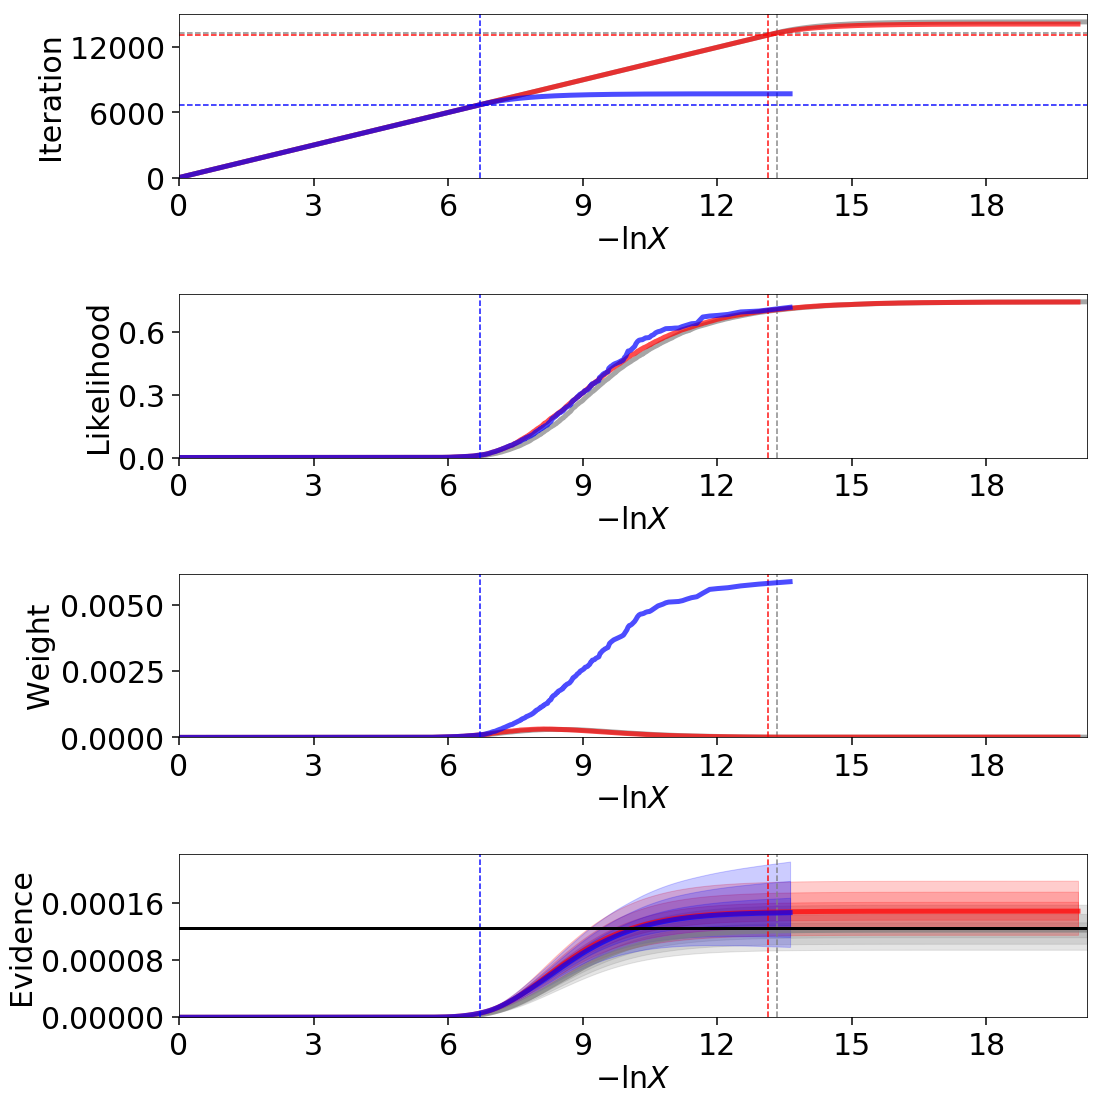

In [21]:
# analytic evidence solution
lnz_truth = ndim * -np.log(2 * 10.)  # log(volume) of prior; log(like) is normalized

# plot parallel run
fig, axes = dyplot.runplot(pres, color='gray')

# plot extended run
fig, axes = dyplot.runplot(res2, color='red', fig=(fig, axes))

# overplot original run
fig, axes = dyplot.runplot(res, color='blue', lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

We see that up until we recycle our final set of live points (indicated by the dashed lines), the relationship between $\ln X_i$ and $i$ is linear (i.e. traversal is logarithmic). Afterwards, however, it flattens out, rapidly traversing the remaining prior volume in linear fashion. While this clearly introduces additional sampling noise, visible in $\mathcal{L}_i$, $\hat{p}_i$, and the errors on $\hat{\mathcal{Z}}$, the overall effect on $\hat{\mathcal{Z}}$ itself is quite muted (especially given the estimated uncertainties).

## Traces and Posteriors

Another standard approach for visualizing how our sampler is doing is looking at the **traces** of individual  particles (i.e. our "dead points") to see what "path" they are taking through the distribution as well as the 1-D **marginalized posteriors** to see how well constrained our results ultimately are (especially given the heavily skewed set of weights often provided by nested sampling, as shown above). 

This can be done using `traceplot`. By default, it returns the samples color-coded by their relative weight and the 1-D marginalized posteriors smoothed by a Gaussian kernel with a standard deviation set to ~2% of the provided range (which defaults to the 5-sigma bounds computed from the set of weighted samples). It also can overplot input truth vectors as well as highlight specific particle paths (shown below) to inspect the behavior of individual particles.

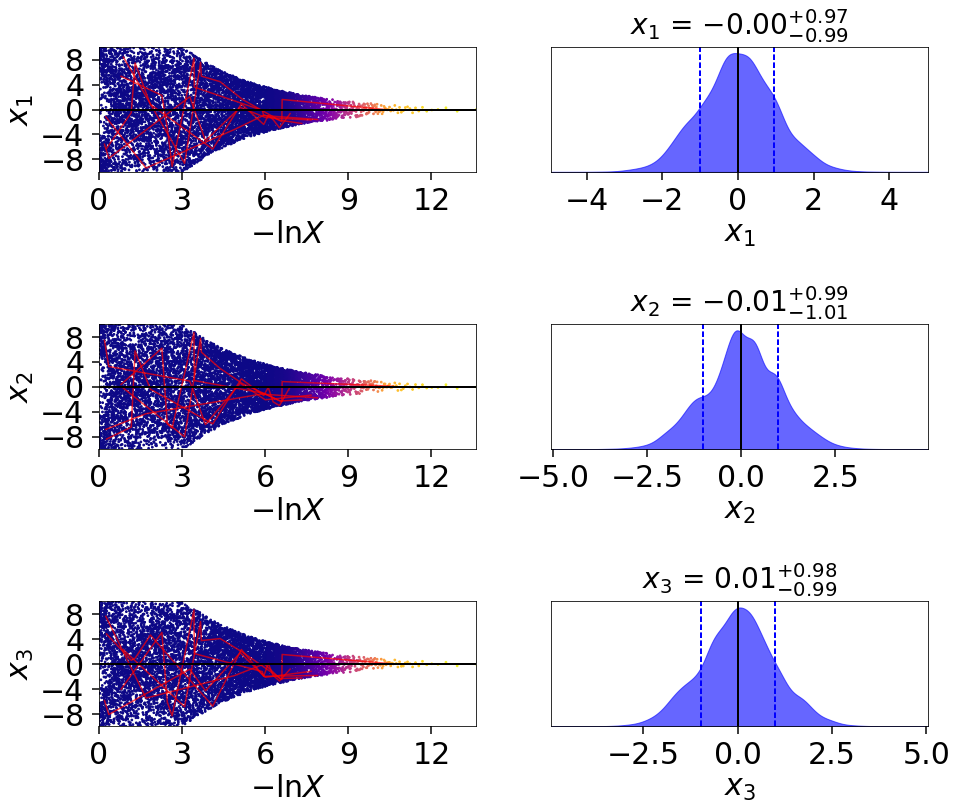

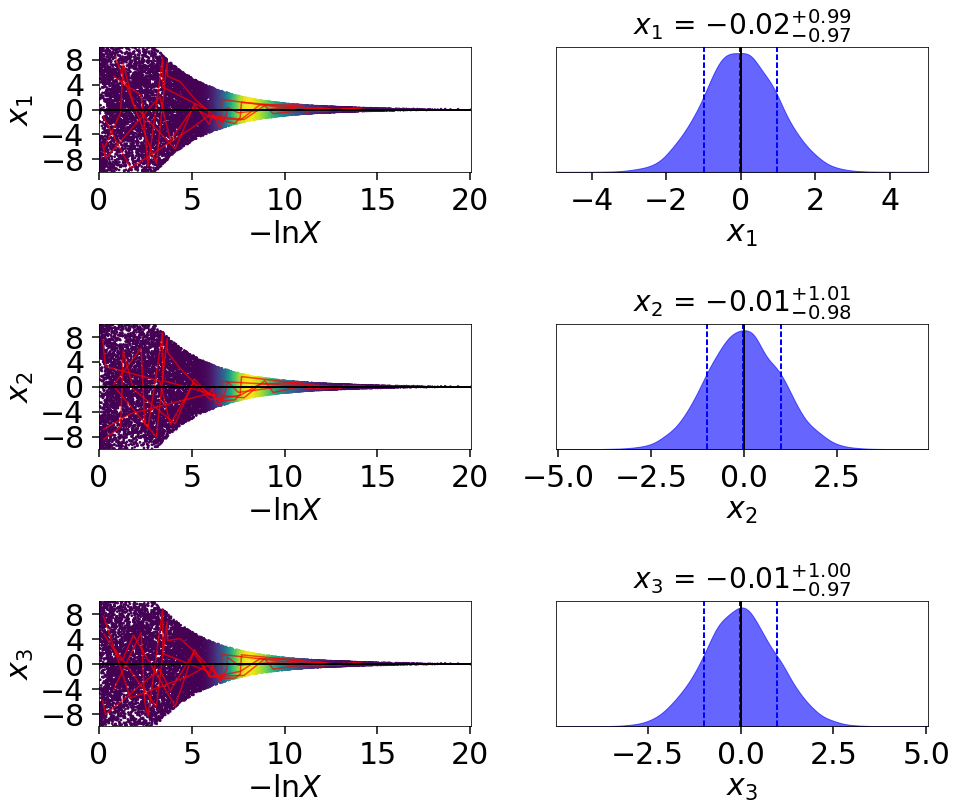

In [22]:
# plotting the original run
fig, axes = dyplot.traceplot(res, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='plasma',
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='viridis',
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

We see that although the evidences we estimate from both runs are almost identical, the (marginalized) posteriors we derive in our extended run is considerably smoother since we have more finely sampled the bulk of the posterior mass (clearly visible in the bottom three left panels). In addition, our particle paths support our assumption that our samples are (essentially) i.i.d. based on the prior within the likelihood constraints at a particular iteration.

## Corner Plots

In addition to trace plots, another common way to visualize (weighted) samples is using **corner plots** (also called triangle plots), which show a combination of 1 and 2-D marginalized posteriors. `dynesty` supports several corner plotting functions (based on the excellent `corner` [package](http://corner.readthedocs.io/en/latest/) by Daniel Foreman-Mackey.)

Let's first take a look at the positions and weights of our individual samples to see where our samples are concentrated using `cornerpoints`.

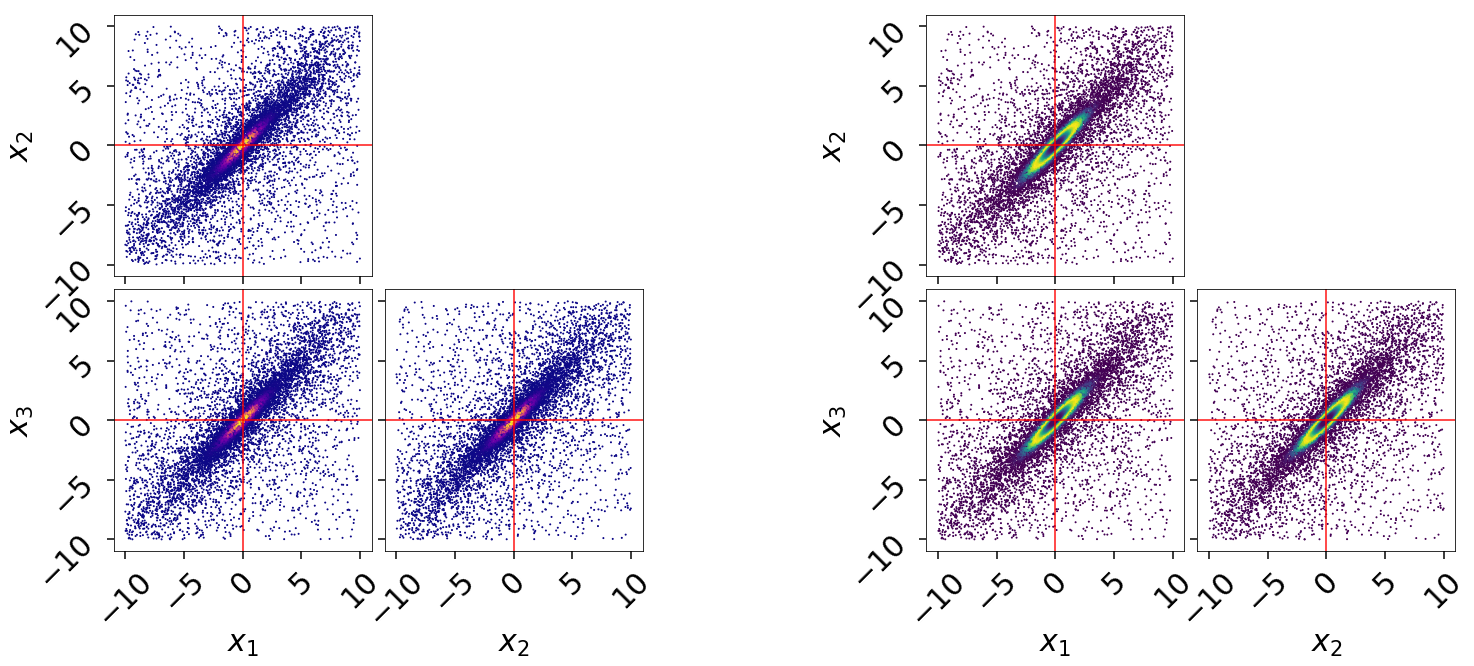

In [23]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=[0., 0., 0.],
                             fig=(fig, axes[:, :2]))

# plot extended run (right)
fg, ax = dyplot.cornerpoints(res2, cmap='viridis', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 3:]))

Just by looking at our projected samples, it is readily apparent that our extended run does a much better job of localizing the overall distribution. Let's try and get a better qualatative handle on this below by plotting the marginal 1-D and 2-D posteriors using `cornerplot`. (Like `runplot`, our distributions are by default smoothed by 2% in the specified range using a Gaussian (Normal) kernel).

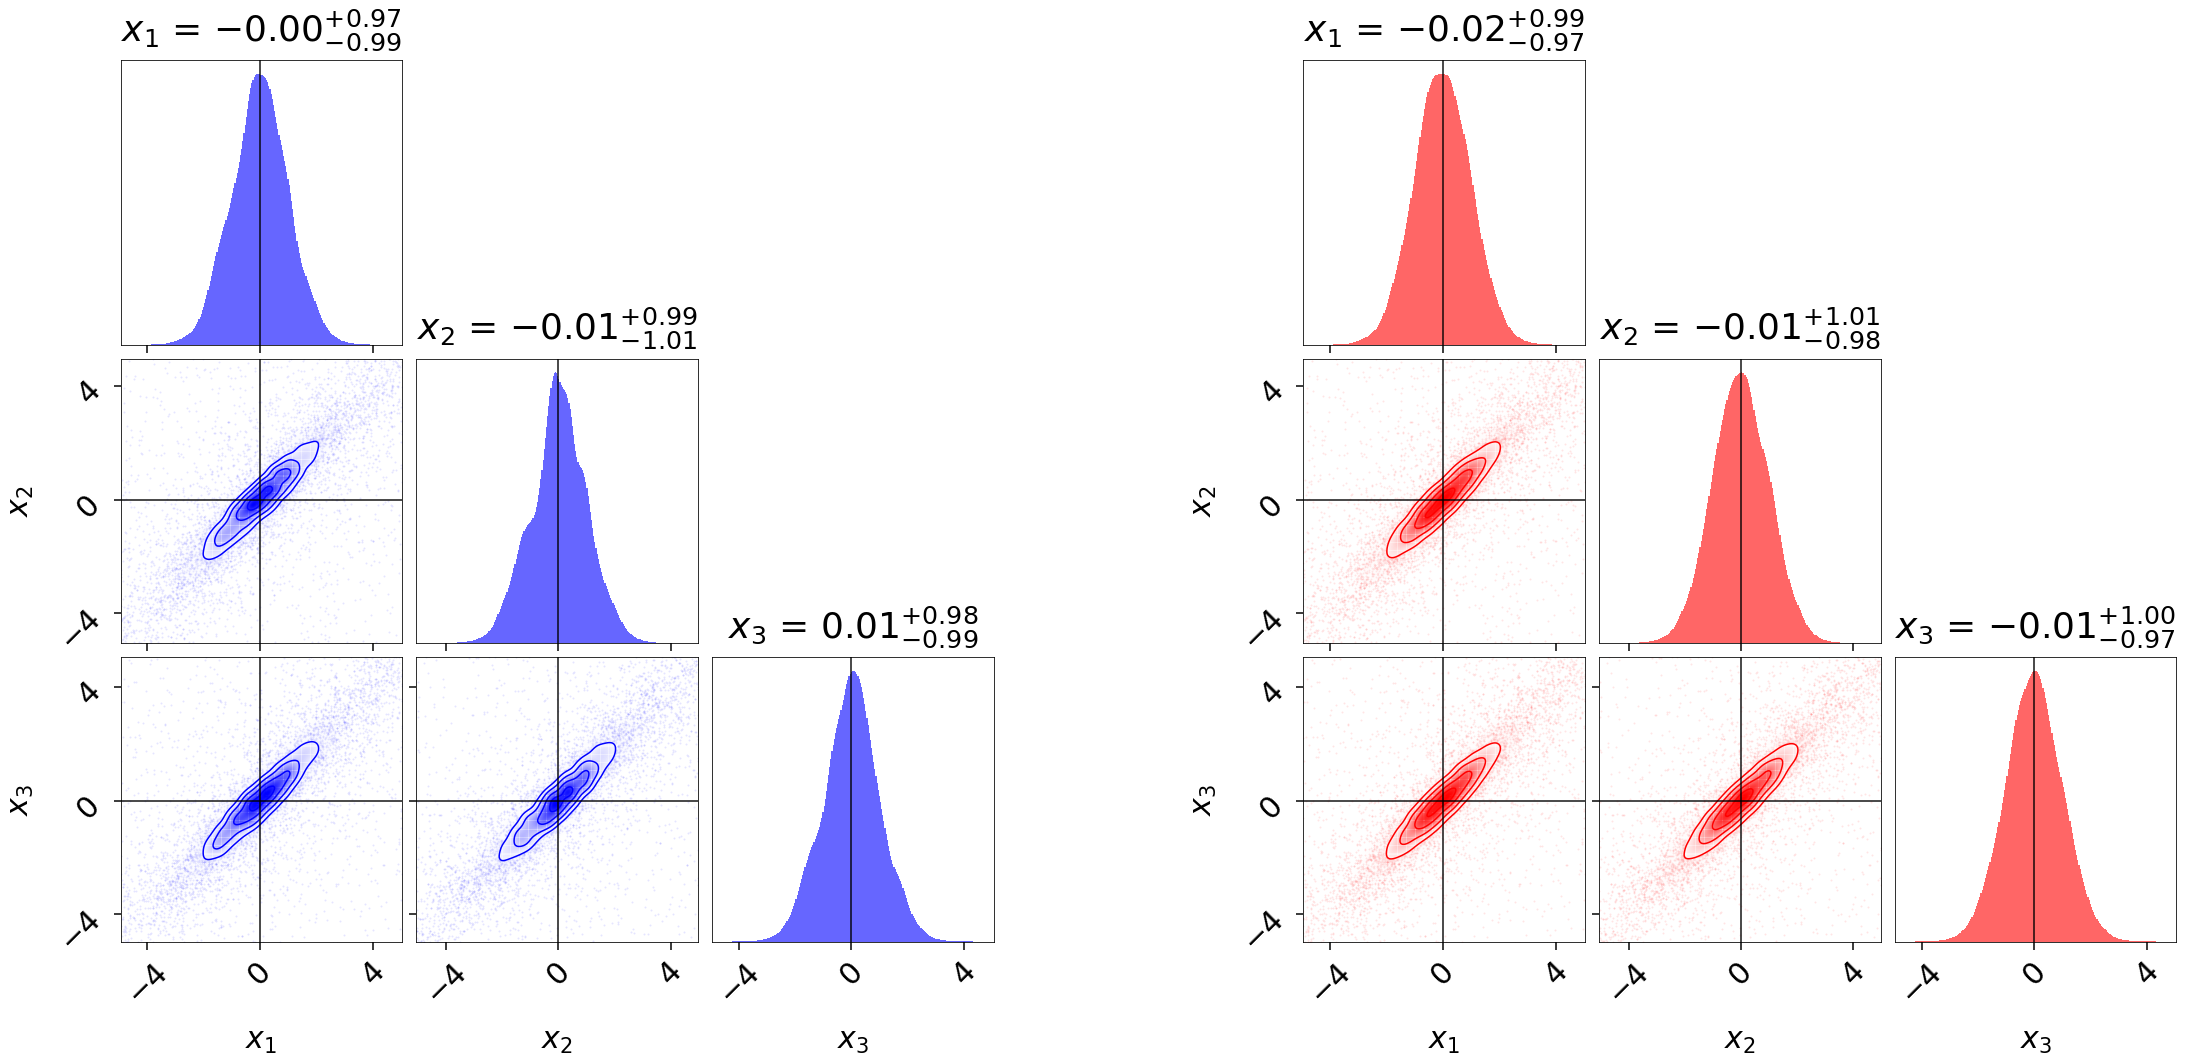

In [24]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

Even though our original run (with 2x less samples) gave similar evidence estimates, it seems to give significantly "noisier" estimates of the posterior than those from our extended run. We'll quantify this more later.

## Evolving Proposals

To visualize how we're sampling in nested "shells", we can look at the evolution of our proposal in a given 2-D projection over the course of the run. The `proposal` function allows us to look at the proposal distributions from two different perspectives: the proposal distribution used to propose new live points at a specific iteration (specified using `it`), or the proposal distribution a given dead point originated from (specified using `idx`). While `proposal` natively plots in the space of the unit cube, if a specified prior transform function is passed all samples are instead converted to the original (native) model space.

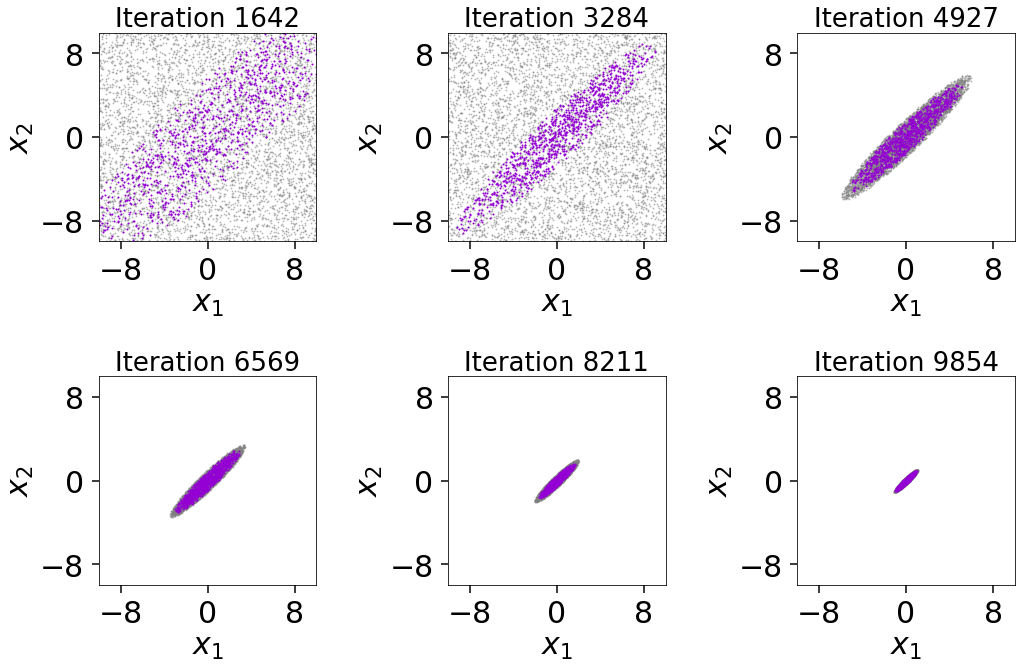

In [25]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*res2.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.proposal(res2, dims=(0, 1), it=it, prior_transform=prior_transform, max_n_ticks=3,
                           show_live=True, bounds=[(-10, 10), (-10, 10)], fig=(fig, a))
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()

Alternately, `cornerprop` generates corner plots for our proposals.

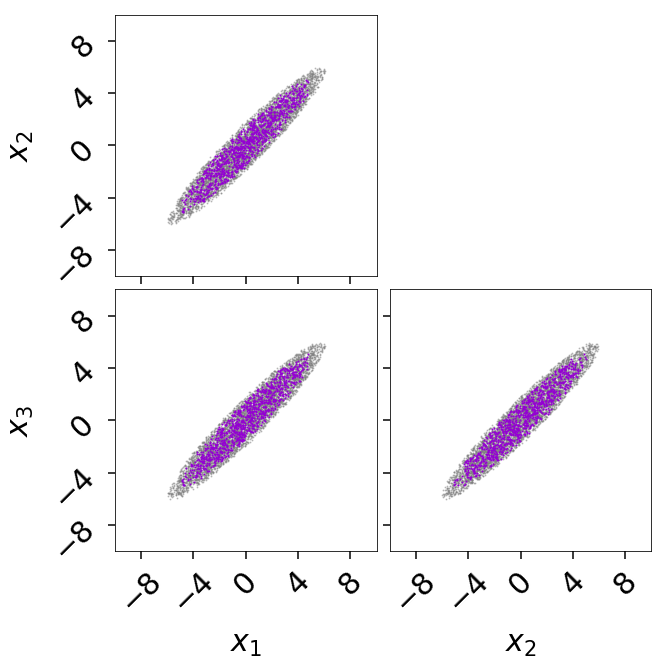

In [26]:
# initialize figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# plot proposals in corner format
fg, ax = dyplot.cornerprop(res2, it=5000, prior_transform=prior_transform, show_live=True, 
                           bounds=[(-10, 10), (-10, 10)], fig=(fig, axes))

We see that our multi-ellipsoid proposals are able to adapt well to the shells over time, ensuring we continue to make efficient proposals without violating our uniform sampling assumptions. We can also see the impact our bootstrapping procedure has on the bounding ellipsoids: they always remain slightly larger than the set of live points. While this slightly decreases our efficiency, it helps ensure we do not "leave out" any likelihood during the course of the run.

# Summary

Nested sampling is a powerful and versatile approach for computing Bayesian evidences (with posterior estimates as a "free" by-product). Various nested sampling algorithms can be implemented using the `NestedSampler` "class" in `dynesty`, which allow for a variety of bounding and sampling methods. Sampling can be done implicitly (within `NestedSampler`) or explicitly (as a generator) depending on the degree of control users want over the outputs. Sampling can also be done in parallel using a user-supplied `pool`. Results can be accessed via the `results` property and can be visualized using several built-in plotting functions (via `plotting`).